In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import re

In [38]:
def getNameByIndex(index):
    if index == 1:
        return "Blocking Pure MPI"
    if index == 3:
        return "Nonblocking with OpenMP"
    if index == 2:
        return "Blocking with OpenMP"
    if index == 4:
        return "Nonblocking Pure MPI"
    return ""

def getName(isCMp, isnCMp, isCPure, isnCPure):
    index = getType(isCMp, isnCMp, isCPure, isnCPure)
    
    return getNameByIndex(index)

def getType(isCMp, isnCMp, isCPure, isnCPure):
    if isCPure:
        return 1
    if(isnCMp):
        return 3
    if(isCMp):
        return 2
    if isnCPure:
        return 4
    return -1

In [39]:
def getData():
    paths = ['outputs', 'outputs1', 'outputs2']
    data = {}
    for path in paths:
        files = [entry for entry in os.scandir(path) if entry.is_file()]
        progress = tqdm(files, desc="Processing files")

        for file in progress:
            isCMp = file.name.startswith('clusterMp') or file.name.startswith('clusterOp')
            isnCMp = file.name.startswith('nclusterMp')
            isCPure = file.name.startswith('cluster') and isCMp == False
            isnCPure = file.name.startswith('ncluster') and isnCMp == False
            match = re.search(r"(\d+)=([\d]+)", file.name)
            if not match:
                print(file.name)
            memorySize = int(match.group(1))
            nodes = int(match.group(2))
            if (isCPure or isnCPure):
                nodes /= 36
            else: nodes /= 6
            with open(file, 'r') as f:
                for line in f:
                    if "Execution time:" in line:
                        key = (getType(isCMp, isnCMp, isCPure, isnCPure), memorySize, nodes)
                        if key not in data:
                            data[key] = {
                                "Name": getName(isCMp, isnCMp, isCPure, isnCPure),
                                "Type": getType(isCMp, isnCMp, isCPure, isnCPure),
                                "Size": memorySize,
                                "Nodes": nodes,
                                "FileName": file.name,
                                "Path": path,
                                "Times": [float(line.split(':')[1].strip())],
                            }
                        else:
                            data[key]["Times"].append(float(line.split(':')[1].strip()))
    
    return pd.DataFrame(data.values())


In [40]:
df = getData()
df = df[df['Times'].apply(len) >= 3]

Processing files: 100%|██████████| 180/180 [00:00<00:00, 1690.77it/s]


In [41]:
def serialMean(size):
    if size == 30000:
        return 3.385
    if size == 3000:
        return 0.033
    
    return 0.00036

def mean(data):
    return serialMean(data["Size"]) / np.mean(data["Times"])

df["Mean"] = df.apply(mean, axis=1)
df["Times_1"] = df.apply(lambda d: d["Times"][0], axis=1)
df["Times_2"] = df.apply(lambda d: d["Times"][1], axis=1)
df["Times_3"] = df.apply(lambda d: d["Times"][2], axis=1)

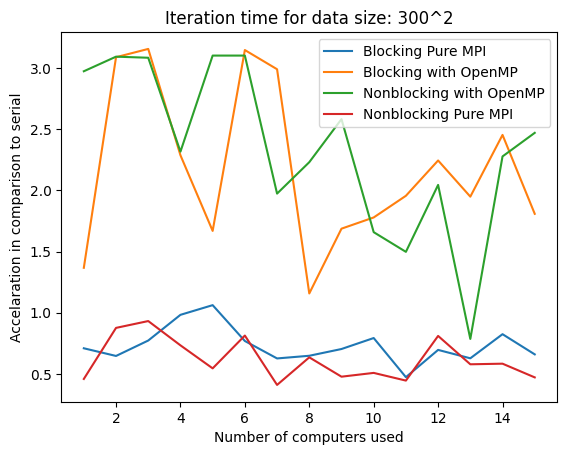

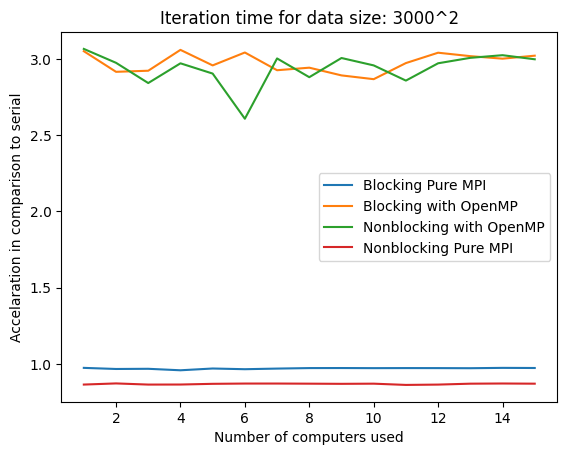

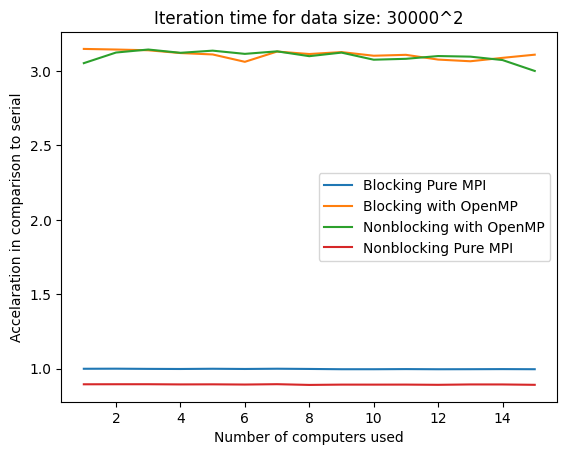

In [42]:
x = range(1, 16)
sizes = [300, 3000, 30000]
for size in sizes:
    tempDf = df[df["Size"] == size]
    plt.plot(x, tempDf[tempDf["Type"] == 1].sort_values(by="Nodes")["Mean"], label=getNameByIndex(1))
    plt.plot(x, tempDf[tempDf["Type"] == 2].sort_values(by="Nodes")["Mean"], label=getNameByIndex(2))
    plt.plot(x, tempDf[tempDf["Type"] == 3].sort_values(by="Nodes")["Mean"], label=getNameByIndex(3))
    plt.plot(x, tempDf[tempDf["Type"] == 4].sort_values(by="Nodes")["Mean"], label=getNameByIndex(4))
    plt.title("Iteration time for data size: " + str(size) + "^2")
    plt.xlabel("Number of computers used")
    plt.ylabel("Accelaration in comparison to serial")
    plt.legend()
    plt.show()

In [43]:
df

,Name,Type,Size,Nodes,FileName,Path,Times,Mean,Times_1,Times_2,Times_3
0,Blocking Pure MPI,1,30000,3.0,cluster30000=108.txt,outputs,"[3.39463, 3.381661, 3.391359]",0.998756,3.394630,3.381661,3.391359
1,Blocking Pure MPI,1,30000,4.0,cluster30000=144.txt,outputs,"[3.407028, 3.384544, 3.383569]",0.998021,3.407028,3.384544,3.383569
2,Blocking Pure MPI,1,30000,5.0,cluster30000=180.txt,outputs,"[3.384166, 3.387225, 3.387872]",0.999580,3.384166,3.387225,3.387872
3,Blocking Pure MPI,1,30000,6.0,cluster30000=216.txt,outputs,"[3.40416, 3.385687, 3.384286]",0.998119,3.404160,3.385687,3.384286
4,Blocking Pure MPI,1,30000,7.0,cluster30000=252.txt,outputs,"[3.386744, 3.385949, 3.384438]",0.999790,3.386744,3.385949,3.384438
...,...,...,...,...,...,...,...,...,...,...,...
175,Nonblocking with OpenMP,3,300,11.0,nclusterMp300=66.txt,outputs,"[0.000273, 0.000238, 0.00021]",1.497920,0.000273,0.000238,0.000210
176,Nonblocking with OpenMP,3,300,12.0,nclusterMp300=72.txt,outputs,"[0.000254, 0.000146, 0.000128]",2.045455,0.000254,0.000146,0.000128
177,Nonblocking with OpenMP,3,300,13.0,nclusterMp300=78.txt,outputs,"[0.000995, 0.000134, 0.000246]",0.785455,0.000995,0.000134,0.000246
178,Nonblocking with OpenMP,3,300,14.0,nclusterMp300=84.txt,outputs,"[0.000146, 0.000125, 0.000203]",2.278481,0.000146,0.000125,0.000203


In [ ]:
nice = df[["Name", "Size", "Nodes", "Times_1", "Times_2", "Times_3"]]
nice.sort_values(by=["Name", "Size", "Nodes"])

,Name,Size,Nodes,Times_1,Times_2,Times_3
37,Blocking Pure MPI,300,1.0,0.000338,0.000847,0.000338
44,Blocking Pure MPI,300,2.0,0.000340,0.000993,0.000338
30,Blocking Pure MPI,300,3.0,0.000424,0.000636,0.000338
31,Blocking Pure MPI,300,4.0,0.000338,0.000338,0.000423
32,Blocking Pure MPI,300,5.0,0.000340,0.000338,0.000339
...,...,...,...,...,...,...
145,Nonblocking with OpenMP,30000,11.0,1.111900,1.073661,1.110293
146,Nonblocking with OpenMP,30000,12.0,1.111653,1.073645,1.090727
147,Nonblocking with OpenMP,30000,13.0,1.111140,1.073904,1.095240
148,Nonblocking with OpenMP,30000,14.0,1.110218,1.073377,1.121187
